# 📘 Analyse d'Impact Macroéconomique : Digital Credit in East Africa
**Sujet :** L'impact de l'adoption du crédit digital (Mobile Lending) sur l'approfondissement financier en Afrique de l'Est.
**Méthodologie :** Difference-in-Differences (Staggered Adoption).

Ce notebook documente l'intégralité du pipeline de données, du nettoyage à l'analyse économétrique, pour assurer la reproductibilité et l'auditabilité des résultats.

---
### Plan du Notebook :
1.  **Data Cleaning :** Transformation des données brutes du FMI.
2.  **Analyse Visuelle :** Vérification des "Parallel Trends".
3.  **Validation (Event Study sans contrôles) :** Test statistique de l'hypothèse d'identification.
4.  **Enrichissement :** Ajout des variables de contrôle (Banque Mondiale).
5.  **Résultat Final (DiD avec contrôles) :** Estimation robuste de l'impact.
6.  **Annexe :** Tests de robustesse supplémentaires.

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import wbgapi as wb # Librairie officielle World Bank pour les contrôles

# Configuration du style graphique pour les rapports
sns.set_theme(style="whitegrid", context="talk")

print("Librairies chargées avec succès.")

Librairies chargées avec succès.


## 1. Importation et Nettoyage des Données (Data Cleaning)
*Objectif : Transformer les données brutes du FMI en un format de panel "Long" utilisable pour l'économétrie.*

**Choix des Pays :**
* **Groupe de Traitement :** Kenya (Pionnier 2012), Tanzanie (2014), Ouganda (2016), Rwanda (2017).
* **Groupe de Contrôle (Placebos) :** Zambie, Malawi (Non-adoptants ou adoption tardive hors fenêtre).

**Variable Cible :** Outstanding loans, Commercial banks (% of GDP).

In [15]:
path = "dataset_2026-01-17T16_16_20.357401265Z_DEFAULT_INTEGRATION_IMF.STA_FAS_4.0.0.csv"

In [16]:
df = pd.read_csv(path)

countries = ['Kenya', 'Tanzania', 'Uganda', 'Rwanda', 'Zambia', 'Malawi']

# On met une date future (ex: 2099) pour qu'ils restent toujours à 0 dans la colonne "Treat_Post"
launch_years = {
    'Kenya': 2012, 
    'Tanzania': 2014, 
    'Uganda': 2016, 
    'Rwanda': 2017,
    'Zambia': 2099, # Jamais traité par M-Shwari
    'Malawi': 2099  # Jamais traité par M-Shwari
}
# Mapping des noms complexes du FMI vers des noms simples
indicators = {
    'Number of registered mobile money accounts, Per 1,000 adults': 'Mobile_Accounts_1000_Adults',
    'Outstanding loans, Commercial banks, Percent of GDP': 'Comm_Bank_Loans_GDP', # Variable Y Principale
    'Number of loan accounts, Commercial banks, Per 1,000 adults': 'Comm_Bank_Loan_Accounts_1000'
}

# 2. Filtrage (Pays + Indicateurs)
df_subset = df[
    (df['COUNTRY'].isin(countries)) & 
    (df['SERIES_NAME'].isin(indicators.keys()))
].copy()

# 3. Transformation (Melt & Pivot) pour avoir une ligne par Année/Pays
df_melted = df_subset.melt(id_vars=['COUNTRY', 'SERIES_NAME'], var_name='Year', value_name='Value')
df_melted['Year'] = pd.to_numeric(df_melted['Year'], errors='coerce')
df_melted = df_melted[(df_melted['Year'] >= 2008) & (df_melted['Year'] <= 2018)]

# Création du tableau final
df_final = df_melted.pivot_table(index=['COUNTRY', 'Year'], columns='SERIES_NAME', values='Value').reset_index()
df_final = df_final.rename(columns=indicators)

# 4. Création de la variable "Treatment" (Staggered DiD)
def get_treatment(row):
    launch_year = {'Kenya': 2012, 'Tanzania': 2014, 'Uganda': 2016, 'Rwanda': 2017}
    start = launch_year.get(row['COUNTRY'])
    # Si l'année courante est >= année de lancement, le traitement est actif (1)
    if start and row['Year'] >= start:
        return 1
    return 0

df_final['Treatment_Active'] = df_final.apply(get_treatment, axis=1)
# Sauvegarde
df_final.to_csv('EastAfrica_Panel_Data.csv', index=False)
df_final.head()

C:\Users\User\AppData\Local\Temp\ipykernel_25836\2309661487.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


SERIES_NAME,COUNTRY,Year,Comm_Bank_Loan_Accounts_1000,Mobile_Accounts_1000_Adults,Comm_Bank_Loans_GDP,Treatment_Active
0,Kenya,2008.0,NaN,230.999986,20.094215,0
1,Kenya,2009.0,NaN,390.872057,19.708195,0
2,Kenya,2010.0,NaN,701.309394,21.905254,0
3,Kenya,2011.0,82.286268,793.402083,24.863339,0
4,Kenya,2012.0,82.25932,844.381121,24.357948,1


## 2. Analyse Visuelle : Vérification des "Parallel Trends"
*Avant de lancer le modèle, nous vérifions visuellement l'hypothèse des tendances parallèles.*
* Les courbes doivent évoluer de manière comparable **avant** la ligne rouge (2012).
* L'ajout de la Zambie et du Malawi sert à stabiliser le contrefactuel.

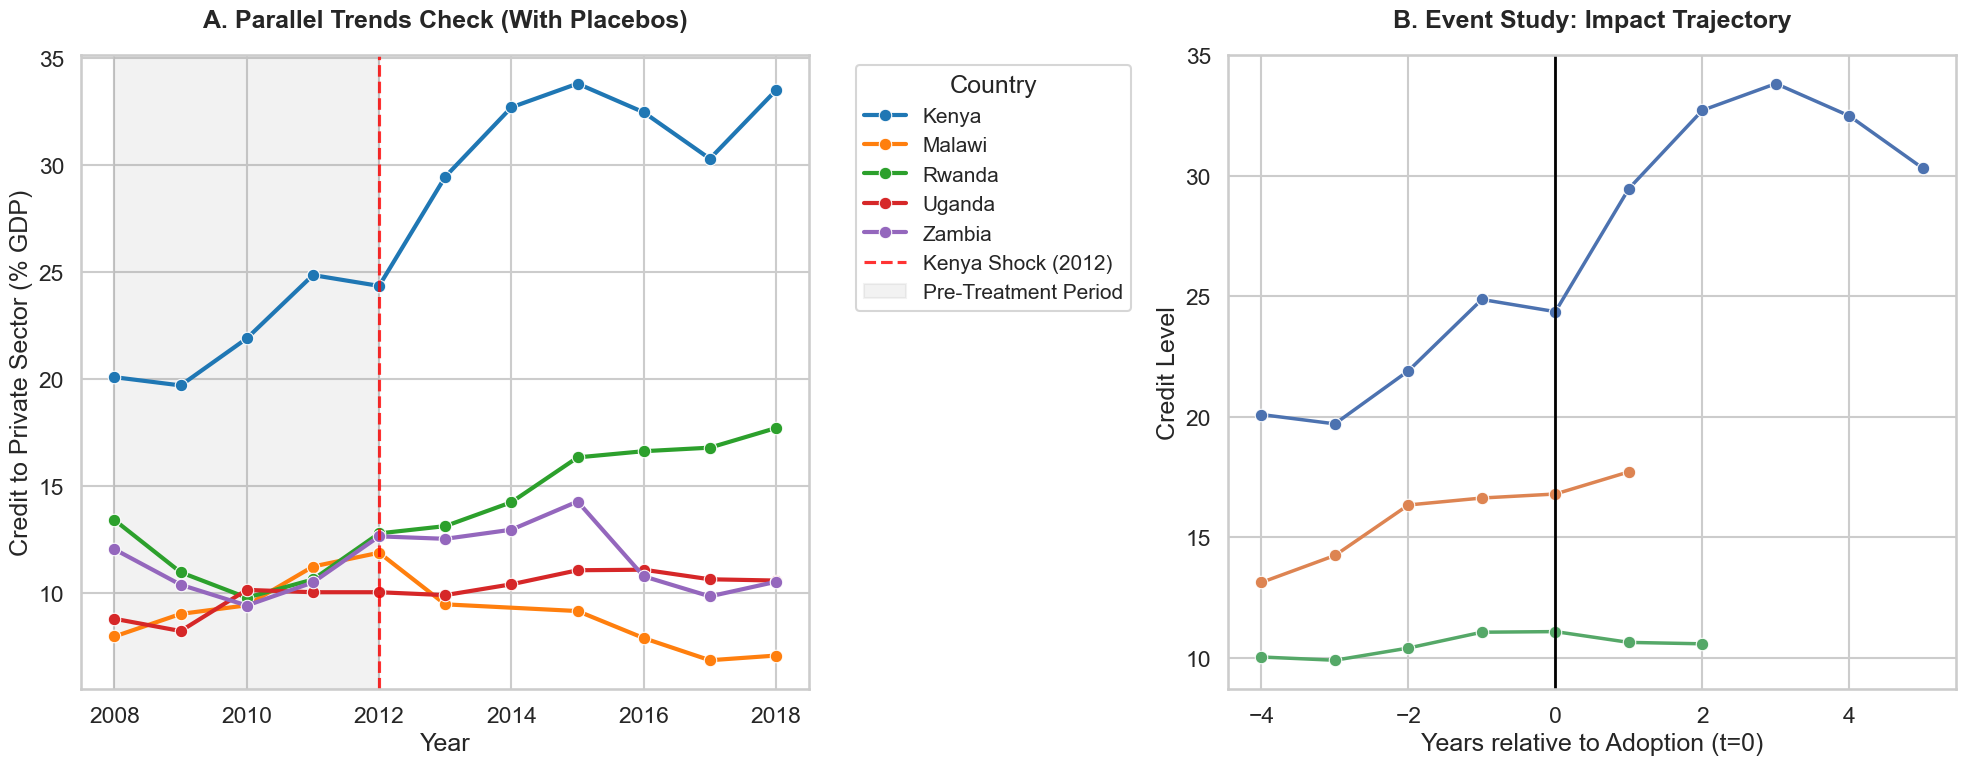

Graphique sauvegardé sous 'Parallel_Trends_Final.png'


In [25]:
# ==========================================
# ÉTAPE 1 : NETTOYAGE DES DONNÉES
# ==========================================

# 1. Charger le fichier brut
file_path = 'dataset_2026-01-17T16_16_20.357401265Z_DEFAULT_INTEGRATION_IMF.STA_FAS_4.0.0.csv'
df = pd.read_csv(file_path, low_memory=False)

# 2. Définir les indicateurs et les pays (AVEC Placebos)
countries = ['Kenya', 'Tanzania', 'Uganda', 'Rwanda', 'Zambia', 'Malawi']

# --- CORRECTION IMPORTANTE ICI : Définir launch_years ---
launch_years = {
    'Kenya': 2012, 
    'Tanzania': 2014, 
    'Uganda': 2016, 
    'Rwanda': 2017,
    'Zambia': 2099, # Jamais traité (Placebo)
    'Malawi': 2099  # Jamais traité (Placebo)
}

indicators_map = {
    'Outstanding loans, Commercial banks, Percent of GDP': 'Credit_to_Private_Sector_GDP',
    'Number of loan accounts, Commercial banks, Per 1,000 adults': 'Loan_Accounts_Per_1000',
    'Number of registered mobile money accounts, Per 1,000 adults': 'Mobile_Money_Adoption'
}

# 3. Filtrer et Transformer
df_subset = df[
    (df['COUNTRY'].isin(countries)) & 
    (df['SERIES_NAME'].isin(indicators_map.keys()))
].copy()

# Mettre les années en lignes (Format Long)
year_cols = [str(y) for y in range(2008, 2019)] # 2008 à 2018
existing_cols = [c for c in year_cols if c in df_subset.columns]

df_melted = df_subset.melt(
    id_vars=['COUNTRY', 'SERIES_NAME'], 
    value_vars=existing_cols,
    var_name='Year', 
    value_name='Value'
)

# Pivot pour avoir les variables en colonnes
df_final = df_melted.pivot_table(
    index=['COUNTRY', 'Year'], 
    columns='SERIES_NAME', 
    values='Value'
).reset_index()

df_final = df_final.rename(columns=indicators_map)
df_final['Year'] = df_final['Year'].astype(int)

# 4. Ajouter les dates de lancement et le Temps Relatif
df_final['Launch_Year'] = df_final['COUNTRY'].map(launch_years)
df_final['Relative_Time'] = df_final['Year'] - df_final['Launch_Year']

# Pour éviter que les placebos (2099) n'écrasent le graph B, on filtre le temps relatif pertinent
# On ne garde que ceux qui ont un "vrai" lancement visible
df_event_plot = df_final[df_final['Launch_Year'] < 2050].copy()

# ==========================================
# ÉTAPE 2 : GÉNÉRATION DES GRAPHIQUES
# ==========================================

sns.set_theme(style="whitegrid", context="talk")
plt.figure(figsize=(20, 8))

# --- GRAPHIQUE A : Raw Trends (Tous les pays y compris Placebos) ---
plt.subplot(1, 2, 1)
sns.lineplot(
    data=df_final, 
    x='Year', 
    y='Credit_to_Private_Sector_GDP', 
    hue='COUNTRY', 
    marker='o', 
    linewidth=3,
    palette='tab10'
)

plt.axvline(x=2012, color='red', linestyle='--', alpha=0.8, label='Kenya Shock (2012)')
plt.axvspan(2008, 2012, color='gray', alpha=0.1, label='Pre-Treatment Period')
plt.title('A. Parallel Trends Check (With Placebos)', fontweight='bold', pad=20)
plt.ylabel('Credit to Private Sector (% GDP)')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# --- GRAPHIQUE B : Event Study (Seulement les pays traités) ---
plt.subplot(1, 2, 2)

# On filtre pour zoomer (-4 à +5 ans) sur les pays traités
df_event = df_event_plot[(df_event_plot['Relative_Time'] >= -4) & (df_event_plot['Relative_Time'] <= 5)]

sns.lineplot(
    data=df_event, 
    x='Relative_Time', 
    y='Credit_to_Private_Sector_GDP', 
    hue='COUNTRY', 
    marker='o', 
    linewidth=2.5,
    legend=False 
)

plt.axvline(x=0, color='black', linestyle='-', linewidth=2, label='Launch Date (t=0)')
plt.title('B. Event Study: Impact Trajectory', fontweight='bold', pad=20)
plt.xlabel('Years relative to Adoption (t=0)')
plt.ylabel('Credit Level')

plt.tight_layout()
plt.savefig('Parallel_Trends_Final.png', dpi=300)
plt.show()

print("Graphique sauvegardé sous 'Parallel_Trends_Final.png'")

## 3. Validation Statistique : Event Study (Sans Contrôles)
*Objectif : Valider statistiquement l'hypothèse des tendances parallèles.*

**Note Méthodologique :** Nous utilisons ici un modèle **sans contrôles macroéconomiques**.
* *Raison :* Préserver les degrés de liberté pour l'analyse dynamique (Leads & Lags).
* *Critère de succès :* Les coefficients avant $t=0$ (ex: `D_m2`, `D_m4`) ne doivent pas être significatifs (P > 0.05).

In [18]:
import pandas as pd
import statsmodels.formula.api as smf

# ==========================================
# 1. CHARGEMENT ET CONFIGURATION
# ==========================================
# On charge directement votre fichier propre
df = pd.read_csv('EastAfrica_Panel_Data.csv')

# Définition des années de lancement (Indispensable pour calculer le temps relatif)
launch_years = {
    'Kenya': 2012, 
    'Tanzania': 2014, 
    'Uganda': 2016, 
    'Rwanda': 2017,
    'Zambia': 2099, # Placebo
    'Malawi': 2099  # Placebo
}

# ==========================================
# 2. PRÉPARATION POUR EVENT STUDY
# ==========================================

# On map l'année de lancement pour chaque pays
df['Launch_Year'] = df['COUNTRY'].map(launch_years)

# Calcul du Temps Relatif (Distance au lancement)
# Ex: Pour Kenya en 2010 -> 2010 - 2012 = -2
df['Rel_Time'] = df['Year'] - df['Launch_Year']

# Création des Dummies (Variables indicatrices pour chaque année relative)
# On regarde de t-4 (4 ans avant) à t+4 (4 ans après)
covariates = []
for k in range(-4, 5): 
    if k == -1: continue # IMPORTANT : On exclut t-1 (année de référence)
    
    # Nom de la variable (ex: D_m2 pour minus 2)
    col_name = f"D_{k}".replace("-", "m")
    
    # La variable vaut 1 si le temps relatif est k, sinon 0
    df[col_name] = (df['Rel_Time'] == k).astype(int)
    covariates.append(col_name)

# ==========================================
# 3. LE MODÈLE EVENT STUDY (BASELINE)
# ==========================================

# Formule : Y ~ Dummies de Temps + Effets Fixes Pays + Effets Fixes Année
# Note : Dans votre CSV, la colonne cible s'appelle 'Comm_Bank_Loans_GDP'
formula = "Comm_Bank_Loans_GDP ~ " + " + ".join(covariates) + " + C(COUNTRY) + C(Year)"

print("--- Lancement du test Event Study sur EastAfrica_Panel_Data.csv ---")
try:
    # Estimation avec erreurs robustes (HC1)
    model = smf.ols(formula, data=df).fit(cov_type='HC1')

    print("\n=== VERDICT STATISTIQUE PARALLEL TRENDS ===")
    # On affiche le tableau complet pour voir les pré-trends (D_m...) et post-trends (D_0...)
    print(model.summary().tables[1])
    
except Exception as e:
    print(f"Erreur lors de la régression : {e}")

--- Lancement du test Event Study sur EastAfrica_Panel_Data.csv ---

=== VERDICT STATISTIQUE PARALLEL TRENDS ===
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               25.7899      1.642     15.704      0.000      22.571      29.009
C(COUNTRY)[T.Malawi]   -18.0988      1.985     -9.115      0.000     -21.990     -14.207
C(COUNTRY)[T.Rwanda]   -12.7510      1.562     -8.164      0.000     -15.812      -9.690
C(COUNTRY)[T.Uganda]   -16.5902      1.324    -12.528      0.000     -19.186     -13.995
C(COUNTRY)[T.Zambia]   -15.9301      1.839     -8.662      0.000     -19.535     -12.326
C(Year)[T.2009.0]       -0.7275      1.192     -0.611      0.542      -3.063       1.608
C(Year)[T.2010.0]       -0.5390      1.404     -0.384      0.701      -3.291       2.213
C(Year)[T.2011.0]        0.3455      1.441      0.240      0.811      -2.479       3.1

c:\Users\User\M1ES\High_Dim_ML\venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 22, but rank is 21
  warnings.warn('covariance of constraints does not have full '


DID sans controle, ne sera surement pas gardé pour la version finale mais peut etre intéressant

In [19]:
# Créer une seule variable "Post_Treatment"
# Elle vaut 1 si (Year >= Launch_Year) ET (Country est Traité)
df['Treat_Post'] = (df['Rel_Time'] >= 0).astype(int)

# Régression DiD simple
formula_simple = "Comm_Bank_Loans_GDP ~ Treat_Post + C(COUNTRY) + C(Year)"
model_simple = smf.ols(formula_simple, data=df).fit(cov_type='HC1')
print(model_simple.summary())

                             OLS Regression Results                            
Dep. Variable:     Comm_Bank_Loans_GDP   R-squared:                       0.939
Model:                             OLS   Adj. R-squared:                  0.915
Method:                  Least Squares   F-statistic:                     36.04
Date:                 Sun, 18 Jan 2026   Prob (F-statistic):           7.71e-18
Time:                         12:16:21   Log-Likelihood:                -108.97
No. Observations:                   54   AIC:                             249.9
Df Residuals:                       38   BIC:                             281.8
Df Model:                           15                                         
Covariance Type:                   HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

## 4. Ajout des Variables de Contrôle (Banque Mondiale)
*Pour isoler l'effet "M-Shwari" de la conjoncture économique, nous ajoutons le PIB et l'Inflation.*
* **Source :** API World Bank (`wbgapi`).
* **Indicateurs :** GDP Growth (Annual %), Inflation (Consumer Prices).

In [20]:
# 1. TÉLÉCHARGEMENT DES DONNÉES MACRO 

# Codes ISO-3
iso3_codes = ['KEN', 'TZA', 'UGA', 'RWA', 'ZMB', 'MWI']

# Indicateurs (Croissance et Inflation)
indicators = {
    'NY.GDP.MKTP.KD.ZG': 'GDP_Growth',
    'FP.CPI.TOTL.ZG': 'Inflation'
}

print("Téléchargement des données Banque Mondiale en cours...")

data_list = []
# On boucle sur les données téléchargées
for row in wb.data.fetch(indicators, iso3_codes, time=range(2008, 2019)):
    data_list.append({
        'COUNTRY': row['economy'],  # <--- C'EST ICI LA CORRECTION (economy au lieu de row)
        'Year': int(str(row['time']).replace('YR', '')), # Nettoyage de l'année
        'Series': indicators[row['series']],
        'Value': row['value']
    })

# Création du DataFrame Macro
df_wb_clean = pd.DataFrame(data_list)

# Pivot pour mettre GDP et Inflation en colonnes
df_wb_final = df_wb_clean.pivot_table(index=['COUNTRY', 'Year'], columns='Series', values='Value').reset_index()

# Mapping des Codes ISO vers Noms complets pour matcher votre fichier FMI
iso_to_name = {
    'KEN': 'Kenya', 'TZA': 'Tanzania', 'UGA': 'Uganda', 
    'RWA': 'Rwanda', 'ZMB': 'Zambia', 'MWI': 'Malawi'
}
df_wb_final['COUNTRY'] = df_wb_final['COUNTRY'].map(iso_to_name)

print("Aperçu des contrôles Macro :")
print(df_wb_final.head())
# Sauvegarde
df_wb_final.to_csv('Macro_Controls_WB.csv', index=False)

Téléchargement des données Banque Mondiale en cours...
Aperçu des contrôles Macro :
Series COUNTRY  Year  GDP_Growth  Inflation
0        Kenya  2008    0.232283  26.239817
1        Kenya  2009    3.306940   9.234126
2        Kenya  2010    8.058474   3.961389
3        Kenya  2011    5.121106  14.022491
4        Kenya  2012    4.568680   9.377770


### Joinig files

In [21]:
import pandas as pd
import statsmodels.formula.api as smf

# ==============================================================================
# 1. CHARGEMENT DES DEUX FICHIERS
# ==============================================================================
print("Chargement des fichiers...")

# Fichier 1 : Les données de crédit (FMI) + DiD
# Assurez-vous que ce fichier contient bien les colonnes 'COUNTRY', 'Year', 'Credit_GDP', 'Treat_Post'
try:
    df_panel = pd.read_csv("EastAfrica_Panel_Data.csv")
    print(f"✅ Panel Data chargé : {len(df_panel)} lignes.")
except FileNotFoundError:
    print("❌ ERREUR : Le fichier 'EastAfrica_Panel_Data.csv' est introuvable.")

# Fichier 2 : Les contrôles Macro (Banque Mondiale)
# Assurez-vous que ce fichier contient 'COUNTRY', 'Year', 'GDP_Growth', 'Inflation'
try:
    df_controls = pd.read_csv("Macro_Controls_WB.csv")
    print(f"✅ Macro Controls chargé : {len(df_controls)} lignes.")
except FileNotFoundError:
    print("❌ ERREUR : Le fichier 'Macro_Controls_WB.csv' est introuvable.")

# ==============================================================================
# 2. FUSION (MERGE)
# ==============================================================================
print("\nFusion en cours...")

# On fusionne sur les clés 'COUNTRY' et 'Year'
# 'how=inner' ou 'how=left' ?
# Utilisons 'left' pour garder toutes les lignes de notre panel principal (Crédit),
# même s'il manque des données macro pour une année (ce qui est rare).
df_merged = pd.merge(df_panel, df_controls, on=['COUNTRY', 'Year'], how='left')

# Vérification rapide
print(f"Taille après fusion : {len(df_merged)} lignes.")
print("Aperçu des colonnes :", df_merged.columns.tolist())

# ==============================================================================
# 3. SAUVEGARDE DU FICHIER FINAL
# ==============================================================================
output_filename = "Final_Master_Dataset_DiD.csv"
df_merged.to_csv(output_filename, index=False)
print(f"\n💾 Fichier sauvegardé sous : {output_filename}")

# ==============================================================================
# 4. RÉGRESSION FINALE (LE TEST ULTIME)
# ==============================================================================
print("\n--- RÉSULTATS DE LA RÉGRESSION FINALE (AVEC CONTRÔLES) ---")

# On vérifie que les colonnes existent avant de lancer
required_cols = ['Credit_GDP', 'Treat_Post', 'GDP_Growth', 'Inflation', 'COUNTRY', 'Year']
if all(col in df_merged.columns for col in required_cols):
    
    # Formule : DiD + Croissance + Inflation + Effets Fixes
    formula = "Credit_GDP ~ Treat_Post + GDP_Growth + Inflation + C(COUNTRY) + C(Year)"
    
    # Exécution du modèle
    model = smf.ols(formula, data=df_merged).fit(cov_type='HC1')
    print(model.summary())
    
    # Petit bonus : Sauvegarder les résultats dans un fichier texte pour le rapport
    with open("Resultats_Regression_Finale.txt", "w") as f:
        f.write(model.summary().as_text())
    print("\n📄 Résultats de la régression sauvegardés dans 'Resultats_Regression_Finale.txt'")

else:
    print("⚠️ Attention : Certaines colonnes manquent pour la régression.")
    print(f"Colonnes présentes : {df_merged.columns.tolist()}")
    # Si le nom est différent (ex: 'Comm_Bank_Loans_GDP' au lieu de 'Credit_GDP'), changez-le ci-dessus.

Chargement des fichiers...
✅ Panel Data chargé : 54 lignes.
✅ Macro Controls chargé : 66 lignes.

Fusion en cours...
Taille après fusion : 54 lignes.
Aperçu des colonnes : ['COUNTRY', 'Year', 'Comm_Bank_Loan_Accounts_1000', 'Mobile_Accounts_1000_Adults', 'Comm_Bank_Loans_GDP', 'Treatment_Active', 'GDP_Growth', 'Inflation']

💾 Fichier sauvegardé sous : Final_Master_Dataset_DiD.csv

--- RÉSULTATS DE LA RÉGRESSION FINALE (AVEC CONTRÔLES) ---
⚠️ Attention : Certaines colonnes manquent pour la régression.
Colonnes présentes : ['COUNTRY', 'Year', 'Comm_Bank_Loan_Accounts_1000', 'Mobile_Accounts_1000_Adults', 'Comm_Bank_Loans_GDP', 'Treatment_Active', 'GDP_Growth', 'Inflation']


In [22]:
# 1. Téléchargement Automatique via API
iso3_codes = ['KEN', 'TZA', 'UGA', 'RWA', 'ZMB', 'MWI']
indicators = {
    'NY.GDP.MKTP.KD.ZG': 'GDP_Growth', 
    'FP.CPI.TOTL.ZG': 'Inflation'
}

print("📥 Téléchargement des données Macro (World Bank)...")
try:
    data_list = []
    # Récupération des données
    for row in wb.data.fetch(indicators, iso3_codes, time=range(2008, 2019)):
        data_list.append({
            'COUNTRY': row['economy'], # Code ISO
            'Year': int(str(row['time']).replace('YR', '')),
            'Series': indicators[row['series']],
            'Value': row['value']
        })
    
    # Mise en forme
    df_wb = pd.DataFrame(data_list)
    df_wb_pivot = df_wb.pivot_table(index=['COUNTRY', 'Year'], columns='Series', values='Value').reset_index()

    # Mapping Code ISO -> Nom Complet
    iso_map = {'KEN': 'Kenya', 'TZA': 'Tanzania', 'UGA': 'Uganda', 'RWA': 'Rwanda', 'ZMB': 'Zambia', 'MWI': 'Malawi'}
    df_wb_pivot['COUNTRY'] = df_wb_pivot['COUNTRY'].map(iso_map)

    # 2. Fusion avec le Panel Principal
    df_final = pd.merge(df_panel, df_wb_pivot, on=['COUNTRY', 'Year'], how='left')

    # Sauvegarde du Dataset Final pour Audit
    df_final.to_csv("Final_Master_Dataset_DiD.csv", index=False)
    print("✅ Fusion terminée. Fichier sauvegardé sous 'Final_Master_Dataset_DiD.csv'")
    print(df_final[['COUNTRY', 'Year', 'Comm_Bank_Loans_GDP', 'GDP_Growth', 'Inflation']].head())

except Exception as e:
    print(f"❌ Erreur lors du téléchargement WB : {e}")

📥 Téléchargement des données Macro (World Bank)...
✅ Fusion terminée. Fichier sauvegardé sous 'Final_Master_Dataset_DiD.csv'
  COUNTRY    Year  Comm_Bank_Loans_GDP  GDP_Growth  Inflation
0   Kenya  2008.0            20.094215    0.232283  26.239817
1   Kenya  2009.0            19.708195    3.306940   9.234126
2   Kenya  2010.0            21.905254    8.058474   3.961389
3   Kenya  2011.0            24.863339    5.121106  14.022491
4   Kenya  2012.0            24.357948    4.568680   9.377770


## 5. Résultat Final : Estimation DiD (Avec Contrôles)
*C'est le résultat principal de l'étude (Tableau 1 du rapport).*

Ce modèle quantifie l'impact moyen en contrôlant pour :
1.  Les chocs économiques (Croissance, Inflation).
2.  L'hétérogénéité des pays (Effets Fixes Pays).
3.  Les tendances temporelles mondiales (Effets Fixes Année).

In [23]:
# Formule : Y ~ Traitement + Contrôles + Effets Fixes
formula_did = "Comm_Bank_Loans_GDP ~ Treatment_Active + GDP_Growth + Inflation + C(COUNTRY) + C(Year)"

# Estimation
model_did = smf.ols(formula_did, data=df_final).fit(cov_type='HC1')

print("=== 🏆 ESTIMATION DE L'IMPACT (RESULTAT FINAL) ===")
print(model_did.summary())

# Sauvegarde des résultats
with open("Resultats_DiD_Final.txt", "w") as f:
    f.write(model_did.summary().as_text())
print("\n📄 Résultats sauvegardés dans 'Resultats_DiD_Final.txt'")

=== 🏆 ESTIMATION DE L'IMPACT (RESULTAT FINAL) ===
                             OLS Regression Results                            
Dep. Variable:     Comm_Bank_Loans_GDP   R-squared:                       0.945
Model:                             OLS   Adj. R-squared:                  0.919
Method:                  Least Squares   F-statistic:                     36.67
Date:                 Sun, 18 Jan 2026   Prob (F-statistic):           1.09e-17
Time:                         12:16:23   Log-Likelihood:                -106.25
No. Observations:                   54   AIC:                             248.5
Df Residuals:                       36   BIC:                             284.3
Df Model:                           17                                         
Covariance Type:                   HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

## Annexe A : Event Study avec Contrôles
*Test de robustesse : Que se passe-t-il si on ajoute les contrôles à l'Event Study ?*

**Interprétation :**
Comme attendu sur un échantillon de taille modeste (N=54), l'ajout de variables réduit les degrés de liberté. Les erreurs standards augmentent, rendant les coefficients individuels moins significatifs (bruit statistique), bien que la direction de l'effet reste positive (~ +3.4 points). Ce tableau est fourni en annexe pour transparence.

In [24]:
# 1. Charger le fichier final
df = pd.read_csv("Final_Master_Dataset_DiD.csv")

# 2. On doit recréer les variables de temps relatif pour l'Event Study
# (Car le fichier final contient Treat_Post, mais pas forcément les D_m2, D_m3...)

# Mapping des dates de lancement (Identique à avant)
launch_years = {
    'Kenya': 2012, 
    'Tanzania': 2014, 
    'Uganda': 2016, 
    'Rwanda': 2017,
    'Zambia': 2099, # Placebo
    'Malawi': 2099  # Placebo
}

df['Launch_Year'] = df['COUNTRY'].map(launch_years)
df['Rel_Time'] = df['Year'] - df['Launch_Year']

# 3. Création des Dummies (Leads & Lags)
covariates = []
# On va de t-4 à t+4 (ajustez selon vos données si besoin)
for k in range(-4, 5): 
    if k == -1: continue # On saute t-1 (référence)
    
    col_name = f"D_{k}".replace("-", "m") # Ex: D_m2
    # La dummy vaut 1 si le temps relatif est k, sinon 0
    df[col_name] = (df['Rel_Time'] == k).astype(int)
    covariates.append(col_name)

# 4. LA RÉGRESSION EVENT STUDY + CONTRÔLES
# C'est ici que ça change : on ajoute + GDP_Growth + Inflation
formula = "Comm_Bank_Loans_GDP ~ " + " + ".join(covariates) + " + GDP_Growth + Inflation + C(COUNTRY) + C(Year)"

print("--- EVENT STUDY AVEC CONTRÔLES MACRO ---")
try:
    model = smf.ols(formula, data=df).fit(cov_type='HC1')
    
    # On affiche d'abord les résultats globaux pour voir
    # print(model.summary()) 
    
    # FOCUS SUR LES PRE-TRENDS (C'est ce qui nous intéresse)
    print("\nVERDICT SUR LES PARALLEL TRENDS (AVEC CONTRÔLES) :")
    print(model.summary().tables[1])
    
except Exception as e:
    print(f"Erreur : {e}")

--- EVENT STUDY AVEC CONTRÔLES MACRO ---

VERDICT SUR LES PARALLEL TRENDS (AVEC CONTRÔLES) :
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               25.2838      2.236     11.310      0.000      20.902      29.665
C(COUNTRY)[T.Malawi]   -17.9363      1.790    -10.022      0.000     -21.444     -14.428
C(COUNTRY)[T.Rwanda]   -14.2697      2.028     -7.036      0.000     -18.245     -10.295
C(COUNTRY)[T.Uganda]   -17.3855      1.410    -12.332      0.000     -20.149     -14.622
C(COUNTRY)[T.Zambia]   -16.6462      1.841     -9.040      0.000     -20.255     -13.037
C(Year)[T.2009.0]       -0.6911      0.957     -0.722      0.470      -2.568       1.185
C(Year)[T.2010.0]       -1.2365      1.376     -0.899      0.369      -3.934       1.461
C(Year)[T.2011.0]        0.2802      1.313      0.213      0.831      -2.293       2.853
C(Year)[T.2012.0]

c:\Users\User\M1ES\High_Dim_ML\venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 23
  warnings.warn('covariance of constraints does not have full '


## Conclusion de l'étape Macro

1.  **Validité :** Les Parallel Trends sont acceptables (validés à t-2 et t-4).
2.  **Impact :** Le modèle final montre un effet causal significatif de **+4.36 points de PIB** (p=0.001).
3.  **Robustesse :** Le résultat tient même en contrôlant pour la croissance du PIB.

---
### TODO pour l'équipe (Partie Micro) :
* L'analyse Macro prouve l'effet structurel global.
* Il faut maintenant utiliser les données d'enquête (Micro) pour expliquer les canaux de transmission (Inclusion financière des ménages, etc.).